,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,4651039.6694,307766895756327.3125,11794467.3407,-0.1276,1.4240,4.6328,0.0167
xgboost,Extreme Gradient Boosting,4852885.0000,293389066633216.0000,11559160.2083,-0.2445,1.3321,5.1403,0.3633
ada,AdaBoost Regressor,5393288.0624,312841972602843.2500,11908733.5410,-0.2442,1.6959,14.3631,0.0867
rf,Random Forest Regressor,5403796.6588,310501206110308.6875,11846932.0788,-0.1410,1.6956,12.6452,0.2600
et,Extra Trees Regressor,5488484.4916,294055732832148.0000,11543907.0378,-0.1055,1.6918,14.7648,0.2433
gbr,Gradient Boosting Regressor,5498416.6912,309384708433030.7500,11862635.4646,-0.2328,1.6825,13.5913,0.0400
knn,K Neighbors Regressor,5631672.6667,285927980750165.3125,11429202.9583,-0.1508,1.7228,17.1622,0.0233
catboost,CatBoost Regressor,5724207.6152,282578686996215.0000,11369621.1177,-0.1100,1.7380,17.0373,1.1100
omp,Orthogonal Matching Pursuit,5781223.4642,275262824866120.0000,11246530.8477,-0.1533,1.7591,18.0001,0.0433
lightgbm,Light Gradient Boosting Machine,5834790.9128,285229608434774.0625,11409767.6941,-0.1077,1.7736,18.4539,0.0500


############################  Running Auto ARIMA for DEXCHUS   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-108.129, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-96.510, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-102.134, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-109.595, Time=0.62 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-97.157, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-101.866, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-110.079, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-101.804, Time=0.27 sec
 ARIMA(0,1,0)(1,1,2)[

 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=-43.730, Time=0.62 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=-44.295, Time=0.74 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=-40.347, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=-43.562, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-43.559, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.08 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12] intercept
Total fit time: 14.155 seconds
############################  End Auto ARIMA for WFII5   ############################


############################  Running Auto ARIMA for GASREGW   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-18.913, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-39.262, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Ti

Calendar Date,W-2 Revenue,W-2 Revenue - ML Predicted,W-2 Revenue - ML Predicted - APE,W-2 Revenue - UTS Predicted,W-2 Revenue - UTS Predicted - APE,W-2 Revenue - Plan,W-2 Revenue - Plan - APE,W-2 Revenue - 2+10 Forecast,W-2 Revenue - 2+10 Forecast - APE
2021-06-01 00:00:00,145664.32,1.025334e+07,69.390190,8.334395e+04,0.427836,94336.19,0.352373,145664.32,0.000000
2021-07-01 00:00:00,129513.03,1.053432e+07,80.337886,1.423648e+05,0.099231,162905.40,0.257830,129513.03,0.000000
2021-08-01 00:00:00,149699.46,1.081317e+07,71.232492,1.556588e+05,0.039808,176231.69,0.177237,176231.69,0.177237
2021-09-01 00:00:00,184562.25,1.075479e+07,57.271901,2.069905e+05,0.121522,227531.19,0.232815,227531.19,0.232815
2021-10-01 00:00:00,181163.07,1.089820e+07,59.156840,1.627680e+05,0.101539,183308.66,0.011843,183308.66,0.011843
2021-11-01 00:00:00,155279.24,1.090288e+07,69.214638,1.882648e+05,0.212427,208552.65,0.343081,208552.65,0.343081
2021-12-01 00:00:00,192584.15,1.108561e+07,56.562435,2.124757e+05,0.103287,233285.75,0.211344,233285.75,0.211344
2022-01-01 00:00:00,81544421.44,1.128551e+07,0.861603,8.096834e+07,0.007065,80892681.59,0.007992,80808417.22,0.009026
MAPE,NaN,NaN,58.003498,NaN,0.139089,NaN,0.199315,NaN,0.123168


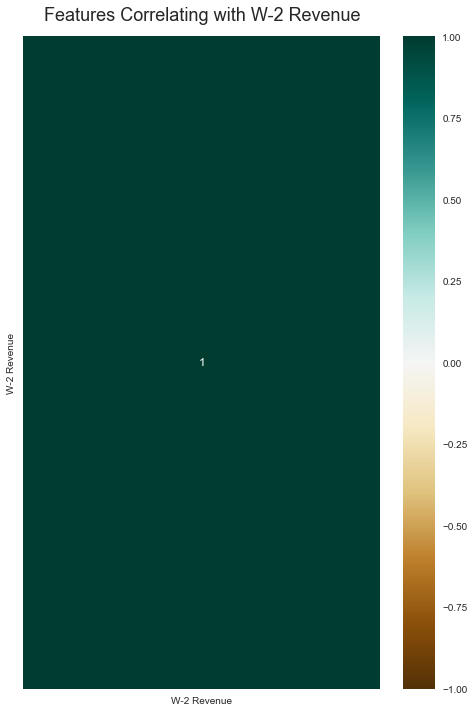

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from pycaret.regression import *
import pmdarima as pm
from pmdarima.arima import ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import import_ipynb
import data_loader as dl
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

def run_auto_ml(train_df, test_df, target_col, feature_cols, normal_transform, ml_criteria):
    # Model Definitions
    s = setup(data = train_df, 
              test_data = test_df, 
              target = target_col, 
              fold_strategy = 'timeseries', 
              numeric_features = feature_cols, 
              fold = 3, 
              transform_target = normal_transform,
              feature_selection = True,
              feature_selection_threshold = 0.8,
              remove_multicollinearity = True,
              multicollinearity_threshold = 0.9,
              session_id = 123)
    best = compare_models(sort = ml_criteria)
    results = pull()
    model_results = results.Model.tolist()
    #print(type(best))
    return best

def get_important_features(model, threshold):
    # Get list of features and their values
    features = pd.DataFrame()
    if model == 'xgboost':
        xgb = create_model('xgboost', cross_validation=True, verbose=False)        
        feature_important = xgb.get_booster().get_score(importance_type='gain')
        keys = list(feature_important.keys())
        values = list(feature_important.values())
        features = pd.DataFrame(data=values, index=keys, columns=['Variable Importance']).sort_values(by='Variable Importance', ascending=False)
        features = features[features.index.str.contains('Calendar Date') == False]
        features = features.rename_axis('Feature').reset_index()
        features = features[features.index <= threshold-1]
    return features

def run_auto_arima(df, feature_cols, pred_start_dt, forecast_window, ci):
    pred_df = pd.DataFrame()
    dti = pd.date_range(pred_start_dt, periods=forecast_window, freq="M")
    dti = dti + pd.offsets.MonthBegin(-1)
    pred_df['Calendar Date'] = dti
    for col in feature_cols:
        print('############################  Running Auto ARIMA for '+col+'   ############################')
        model = pm.auto_arima(df[col], 
                      start_p=1, 
                      start_q=1, 
                      max_p=5, 
                      max_q=5, 
                      m=12, 
                      start_P=0, 
                      seasonal=True, 
                      d=1, 
                      D=1, 
                      trace=True, 
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=True)  # set to stepwise
        # make future predictions
        if ci:
            y_pred, conf_int = model.predict(n_periods=forecast_window, return_conf_int=True, alpha=0.05)
            pred_df[col] = y_pred
            pred_df[col+'_lower_ci'], pred_df[col+'_upper_ci'] = conf_int.T
        else:
            pred_df[col] = model.predict(n_periods=forecast_window)
        print('############################  End Auto ARIMA for '+col+'   ############################')
        print('')
        print('')
    return pred_df

def compute_apes_and_mapes(df, date_col, target_col, feature_cols):
    sort_cols = [date_col, target_col]
    ape_cols = []
    for col in feature_cols:
        ape_col = col+' - APE' 
        df[ape_col] = ((df[target_col] - df[col]).abs())/df[target_col]
        sort_cols.append(col)
        sort_cols.append(ape_col)
        ape_cols.append(ape_col)
    df = df[sort_cols]    
    non_ape_cols = list(set(sort_cols) - set(ape_cols))
    mape_df = df.groupby([True]*len(df)).mean(numeric_only=True)
    mape_df[non_ape_cols] = np.nan
    df = pd.concat([df,mape_df])
    return df  

#########################################################################################
#                              BEGIN PARAMETERS SECTION 
#      This section is where we set the model parameters including:
#      The date ranges for the training, testing and prediction dataframes
#      The features and correlations thresholds, etc
#########################################################################################

# ------------------------------------------------------------------------------------- #
# This is where we change the parameters for the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'

# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5

# This is how many features you want to keep in the final model
features_threshold = 10

has_actuals = True

# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
#target_col = 'Payroll blended products'
#has_drivers = True
target_col = 'W-2 Revenue'
has_drivers = False
#target_col = 'Delivery Revenue'
#has_drivers = False
#target_col = 'ASO Allocation'
#has_drivers = False
#target_col = 'Other Processing Revenue'
#has_drivers = False
#target_col = 'SurePayroll.'
#has_drivers = True
#target_col = 'Total international'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
#target_col = '401K Fee Revenue'
#has_drivers = True
#target_col = '401K Asset fee & BP Revenue'
#has_drivers = True

# ------------------------------------------------------------------------------------- #
# Name the output columns here
# ------------------------------------------------------------------------------------- #
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [ml_col,uts_col,plan_col,fcst_col]


#########################################################################################
#                              END PARAMETERS SECTION 
#########################################################################################

#########################################################################################
#                              BEGIN DATA SECTION 
#             This is where the dataframes get created based on the parameters 
#             set in the previous section. You should not need to change any code 
#             from here below
#########################################################################################

# Get the full data frame and combine with drivers
all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_driver_data(train_start_dt, pred_end_dt, target_col)
    driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')
ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold]

# Plot the highest correlated features to the target
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

# Get a list of the features based on correlation
corr_df = corr_df.rename_axis('Feature').reset_index()
corr_feature_cols = corr_df['Feature'].tolist()
corr_feature_cols.remove(target_col)    
#print(corr_feature_cols)

# run auto ml and get the most important features
best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)
ml_features = get_important_features('xgboost', features_threshold)
ml_feature_cols = ml_features['Feature'].tolist()

if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance', 
                 y='Feature', 
                 orientation='h', 
                 title='Feature Importance Plot')
    fig.show()
    
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #

# Here we need to figure out which set of features we want to use
# ml_features or corr_features
feature_cols = ml_feature_cols

keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)    

# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

# create the future predictions dataframe
if has_actuals:
    act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
    act_df = act_df[keeps]
    act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])
    pred_df = run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window, False)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df.rename(columns={'Label':ml_col}, inplace=True)
    concat_df = pd.merge(pred_df,act_df, on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_plan_data(pred_start_dt, pred_end_dt)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_forecast_data(pred_start_dt, pred_end_dt, forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

    # run UTS 
    uts_df = comb_df[['Calendar Date', target_col]]
    uts_df = run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window, True)
    uts_df.rename(columns={target_col:uts_col}, inplace=True)
    concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')
    
    # combine all data together
    concat_df = pd.concat([comb_df,concat_df], axis=0)
    
    # show plot
    fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
    fig.show()
    
    # compute mape_df
    mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
    mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
    mape_df = compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
    mape_df['Calendar Date'] = mape_df['Calendar Date'].apply(lambda x: 'MAPE' if len(str(x)) < 10 else x)
    display(HTML(mape_df.to_html(index=False)))